In [1]:
# Common
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image

# Less common
import time
import os
from collections import namedtuple

# Custom
from dzlib.nn_models.unet import UNet
from dzlib.utils.helper import info, stats, npshow, params, janimate

print(f"Imports complete")


Imports complete


In [2]:
# General settings
dtype = torch.FloatTensor
# %matplotlib inline
%matplotlib notebook
matplotlib.rcParams['savefig.dpi'] = 80
matplotlib.rcParams['figure.dpi'] = 80


# Loading Image

In [3]:
# Path Data & loading functions
cwd = os.getcwd()
data_dir = '/data/'
path = lambda fname : cwd + data_dir + fname
load_pil = lambda image_path : Image.open(image_path)

# Balloon
fname = 'balloons.jpg'
balloons = path(fname)




(648, 431)

original image_np info:
dtype: uint8
shape: (3, 431, 648)

original image_np stats:
max:  255.0000
min:  0.0000
mean: 99.7588
std:  66.1295

cropped image_np info:
dtype: float64
shape: (3, 416, 640)

cropped image_np stats:
max:  1.0000
min:  0.0000
mean: 0.3911
std:  0.2585


<IPython.core.display.Javascript object>


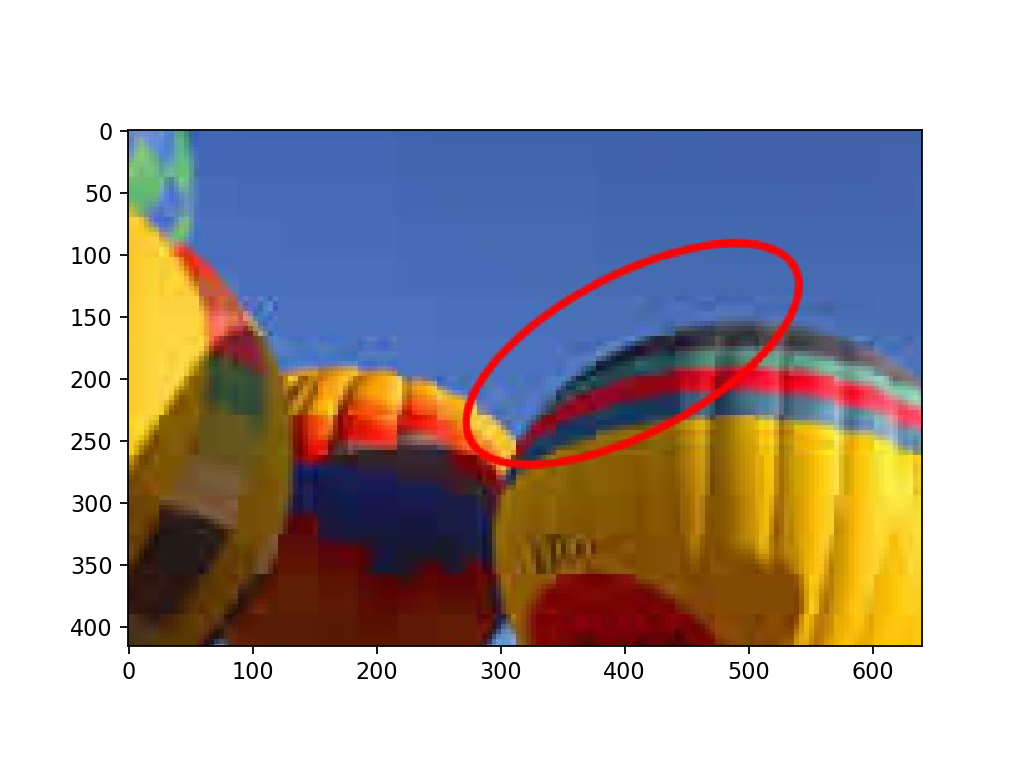

In [4]:
# namedtuple structure for images of structure (array, channels, height, width)
Dims = namedtuple('Dims', 'channels height width')

# Load image (change name here if different image)
image_pil = load_pil(balloons)
print(image_pil.size)

# Convert pil to np from (W x H) to (H x W x C) to (C x H x W)
image_np = np.asarray(image_pil).transpose(2, 0, 1)
image = Dims(*image_np.shape)
info(image_np, 'original image_np')
stats(image_np, 'original image_np')

# Center Crop Image such that height and width are divisible by 32
factor = 32

# bottom - top slice
bot = (image.height % factor) / 2
top = image.height - bot
bot, top = int(bot), int(top)

# left - right slice
left = (image.width % factor) / 2
right = image.width - left
left, right = int(left), int(right)

image_np = image_np[:, bot: top, left: right]
image = Dims(*image_np.shape)

# Normalize Image
image_np = image_np / 255
info(image_np, 'cropped image_np')
stats(image_np, 'cropped image_np')

fig, ax = plt.subplots(1)
npshow(image_np, ax)

# Initialize Net Input & Net Target

In [5]:
std_scaler = 1./10.
ninput = torch.zeros(1, image.channels, image.height, image.width)
ninput = ninput.uniform_() * std_scaler
info(ninput, 'ninput')
stats(ninput, 'ninput')

ninput_saved = ninput.detach().clone()
noise = ninput.detach().clone()

target = torch.from_numpy(image_np).view(ninput.shape)
info(target, 'target')
stats(target, 'target')


ninput info:
dtype: torch.float32
shape: torch.Size([1, 3, 416, 640])

ninput stats:
max:  0.1000
min:  0.0000
mean: 0.0500
std:  0.0289

target info:
dtype: torch.float64
shape: torch.Size([1, 3, 416, 640])

target stats:
max:  1.0000
min:  0.0000
mean: 0.3911
std:  0.2585


# Initialize Net

In [6]:
print(UNet.__init__.__doc__)
print(UNet.activations)
print(UNet.Conv._fields)
print(UNet.Upsample._fields)

 Args:
                ints:
                in_channels: number of input channels of UNet input (used as in_channels in first encoder block)
                out_channels: number of output channels of UNet output (used as out_channels in last block)

                lists of ints:
                down_channels: number of output channels within each successive depth of the UNet Encoder main branch
                skip_channels number of output channels within each successive depth of the UNet Encoder skip branch
                up_channels: number of output channels within each successive depth of the UNet Decoder main branch

                lists of namedtuples of structure (kernel_size, stride, padding, padding_mode), passed as input args for nn.Conv2d()
                down_convs: convblock1 and convblock2 args of the UNet Encoder main branch convblocks
                skip_convs: convblock1 args of the UNet Encoder skip branch convblock
                up_convs: convblock1 and conv

In [7]:
pad = 'reflect'
upsample_mode = 'bilinear'

in_channels = image.channels
out_channels = image.channels

down_channels = [8, 16, 32, 64, 128]
skip_channels = [0, 0, 0, 4, 4]
up_channels = [8, 16, 32, 64, 128]

down_conv1 = UNet.Conv(3, 2, pad)
down_conv2 = UNet.Conv(3, 1, pad)
down_convs = [down_conv1, down_conv2]

skip_conv1 = UNet.Conv(1, 1, pad)
skip_convs = [skip_conv1]

up_conv1 = UNet.Conv(3, 1, pad)
up_conv2 = UNet.Conv(1, 1, pad)
up_convs = [up_conv1, up_conv2]

batchnorm = True
last_batchnorm = None

activation = 'leakyrelu'
last_activation = 'sigmoid'

upsample_args = UNet.Upsample(None, 2, upsample_mode, None)

net = UNet(in_channels, out_channels, down_channels, skip_channels, up_channels, \
           down_convs, skip_convs, up_convs, batchnorm, last_batchnorm, activation, last_activation, upsample_args)

n_params = params(net)
print(f"Number of Params in {UNet.__name__}: {n_params}")



Number of Params in UNet: 572827


<IPython.core.display.Javascript object>


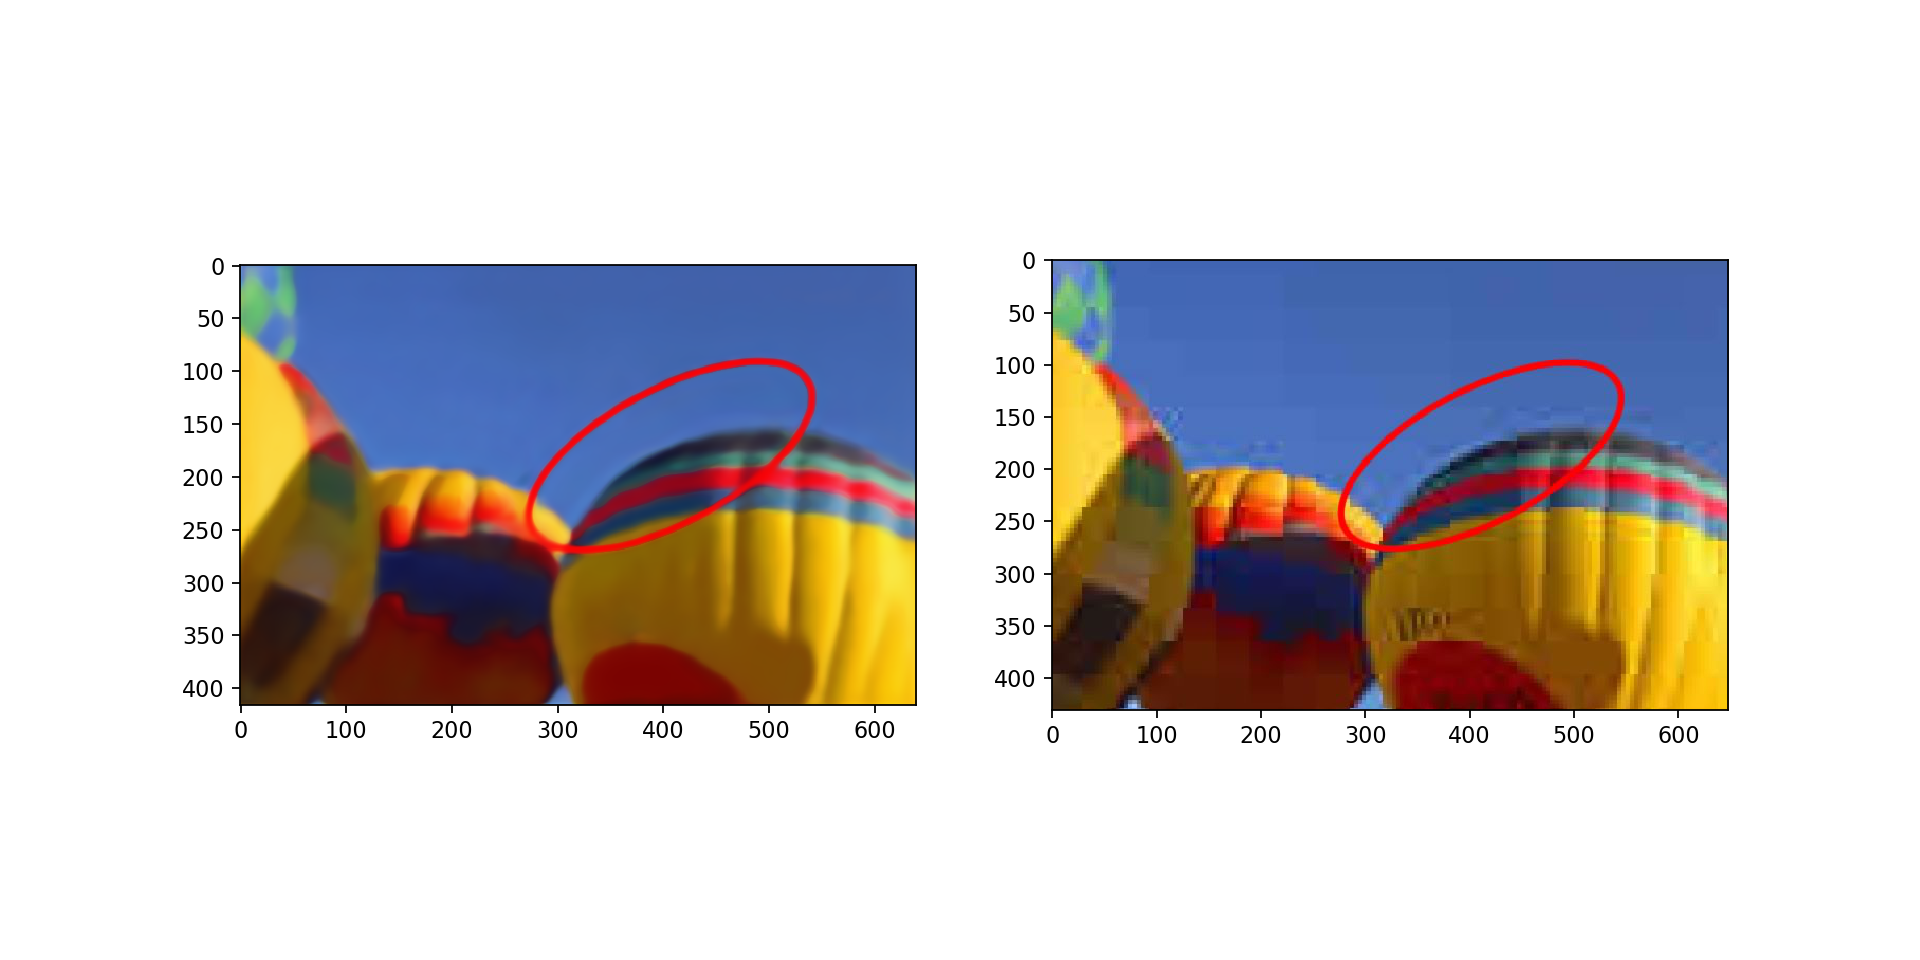

In [11]:
mse = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)
n_iters = 2400
fig, ax = plt.subplots(1, figsize=(12, 6), ncols=2)


In [12]:


# Noise STD (for Regularization), Exp Weight (for smoothing)
noise_std = 1./30.
exp_weight = 0.99
losses = []

ninput = ninput.type(dtype)
target = target.type(dtype)
net = net.type(dtype)
mse = mse.type(dtype)

remove = True

for i in range(n_iters):
    start_time = time.time()
    # Zero Gradients
    optimizer.zero_grad()
    
    # Input Regularization
    ninput = ninput_saved + noise.normal_() * noise_std
    
    # Forward Pass
    out = net(ninput)
    
    # Output Smoothing
    if i == 0:
        out_avg = out.detach()
    else:
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)
        
    # Loss Evaluation
    loss = mse(out, target)
    
    # Back Propagation
    loss.backward()
    
    # Update Weights
    optimizer.step()
    
    losses.append(loss.item())
    print(f'\rIteration {i+1:05d}... Loss {loss.item():.4f}... Time = {(time.time() - start_time):.4f}s', end='')
    
    if i == n_iters - 1:
        remove = False
    out_np = out.detach().cpu().numpy()[0].transpose(1, 2, 0)
    janimate(fig, [out_np, image_pil], [ax[0].imshow, ax[1].imshow], remove)
    
    
    
    


/Users/dziyaee/opt/anaconda3/envs/dz_standard/lib/python3.7/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Iteration 01116... Loss 0.0009... Time = 0.8974s

KeyboardInterrupt: 